<a href="https://colab.research.google.com/github/rohan-pradhan/BitPlaneSlicingAdversarialDefense/blob/master/FINAL_model_nonsliced_mode_0_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -qq -e git+http://github.com/tensorflow/cleverhans.git#egg=cleverhans
import sys
sys.path.append('/content/src/cleverhans')
import cleverhans

    100% |████████████████████████████████| 51kB 4.6MB/s 


In [0]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf
import os
import numpy as np
from google.colab import drive
drive.mount('/content/drive')


Using TensorFlow backend.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing Data

In [0]:
batch_size = 32
num_classes = 10
epochs = 100
data_augmentation = False
num_predictions = 20
save_dir = "/content/drive/My Drive/ECE1512-FinalProject/saved_models"
full_file = save_dir+"/test.txt"
    
print (save_dir)
model_name = 'keras_cifar10_trained_model_nonsliced.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)




/content/drive/My Drive/ECE1512-FinalProject/saved_models
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


# Model


In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])



# Bit Plane Slicing Pre Processor

In [0]:
def last_bit_mode(x):  
  i = np.full(x.shape, 1)
  #print(t.shape,i.shape)
  t = x&i
#   print(np.unique(t))
#   print(t.shape)
  
  tr = t.reshape(-1)
  
  if np.bincount(tr)[0]>np.bincount(tr)[1]:
    lsbm = 0
  else:
    lsbm = 1
  
  return lsbm

def slice(x,n): 
  for i in range(n):
    shifted = x>>i
    lsbm = last_bit_mode(shifted)
    if lsbm == 0:
      mask = np.full(x.shape, 254)
      x = x&((mask<<i) | (2**i - 1))
    else:
      mask = np.full(x.shape, 1)
      x = x|(mask<<i)
    
    #print(lsbm)
    #print(t.shape,i.shape)
#   print(np.unique(x))
#   print(x.shape)
  return x

# Model Training

In [0]:

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)




[  0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34
  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70
  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100 102 104 106
 108 110 112 114 116 118 120 122 124 126 128 130 132 134 136 138 140 142
 144 146 148 150 152 154 156 158 160 162 164 166 168 170 172 174 176 178
 180 182 184 186 188 190 192 194 196 198 200 202 204 206 208 210 212 214
 216 218 220 222 224 226 228 230 232 234 236 238 240 242 244 246 248 250
 252 254]
(10000, 32, 32, 3)
Not using data augmentation.


NameError: ignored

In [0]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Evaluation

First, we will upload the trained model


In [0]:
classifier = tf.keras.models.load_model("keras_cifar10_trained_model_nonsliced.h5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


## Evaluation without Bit Plane Slicing

### Evaluation with Clean Examples


In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() #Import data just in case to maintain consistency 

x_test = x_test/255 # normalize the data 

y_test = keras.utils.to_categorical(y_test, num_classes)

acc = classifier.evaluate(x_test, y_test)

print ("Accuracy: ", acc[1])

10000/10000 [==============================] - 2s 171us/sample - loss: 0.7024 - acc: 0.7745
Accuracy:  0.7745


### Evaluation with Carlini Wagner Attack 

In [0]:
x_test = np.load('attack_images_np_CW_LR_07.npy') # load the Carlini Wagner Adversarial Examples 

acc = classifier.evaluate(x_test, y_test)

print ("Accuracy: ", acc[1])


10000/10000 [==============================] - 2s 158us/sample - loss: 2.2181 - acc: 0.1171
Accuracy:  0.1171


### Evaluation with FGSM Attacks


#### Epsilon = 0.005


In [0]:
x_test = np.load('attack_images_np_FGSM_eps_005.npy') # load the FGSM eps = 0.005 Adversarial Examples 

acc = classifier.evaluate(x_test, y_test)

print ("Accuracy: ", acc[1])

10000/10000 [==============================] - 2s 178us/sample - loss: 1.3928 - acc: 0.5390
Accuracy:  0.539


#### Epsilon = 0.009

In [0]:
x_test = np.load('attack_images_np_FGSM_eps_009.npy') # load the FGSM eps = 0.009 Adversarial Examples 

acc = classifier.evaluate(x_test, y_test)

print ("Accuracy: ", acc[1])

10000/10000 [==============================] - 2s 151us/sample - loss: 1.9325 - acc: 0.3957
Accuracy:  0.3957


#### Epsilon = 0.02


In [0]:
x_test = np.load('attack_images_np_FGSM_eps_02.npy') # load the FGSM eps = 0.02 Adversarial Examples 

acc = classifier.evaluate(x_test, y_test)

print ("Accuracy: ", acc[1])

10000/10000 [==============================] - 2s 153us/sample - loss: 2.6435 - acc: 0.2339
Accuracy:  0.2339


#### Epsilon = 0.04

In [0]:
x_test = np.load('attack_images_np_FGSM_eps_04.npy') # load the FGSM eps = 0.04 Adversarial Examples 

acc = classifier.evaluate(x_test, y_test)

print ("Accuracy: ", acc[1])

10000/10000 [==============================] - 2s 155us/sample - loss: 2.8548 - acc: 0.1665
Accuracy:  0.1665


#### Epsilon = 0.07

In [0]:
x_test = np.load('attack_images_np_FGSM_eps_07.npy') # load the FGSM eps = 0.07 Adversarial Examples 

acc = classifier.evaluate(x_test, y_test)

print ("Accuracy: ", acc[1])

10000/10000 [==============================] - 2s 153us/sample - loss: 2.5770 - acc: 0.1392
Accuracy:  0.1392


## Evaluation with Bit Plane Slicing


### Evaluation with Clean Examples

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() #Import data just in case to maintain consistency 

y_test = keras.utils.to_categorical(y_test, num_classes)

clean_accs = []
for i in range(0, 9):
  print ("Testing with ", i, " bits")
  x_test_slice = x_test
  x_test_slice = x_test.astype('int')
  x_test_slice = slice(x_test, i)
  x_test_slice = x_test_slice.astype('float32')
  x_test_slice /= 255
  acc = classifier.evaluate(x_test_slice, y_test)
  clean_accs.append(acc[1])

Testing with  0  bits
10000/10000 [==============================] - 3s 270us/sample - loss: 0.7024 - acc: 0.7745
Testing with  1  bits
10000/10000 [==============================] - 2s 219us/sample - loss: 0.7032 - acc: 0.7753
Testing with  2  bits
10000/10000 [==============================] - 2s 174us/sample - loss: 0.7061 - acc: 0.7738
Testing with  3  bits
10000/10000 [==============================] - 2s 170us/sample - loss: 0.7163 - acc: 0.7731
Testing with  4  bits
10000/10000 [==============================] - 2s 163us/sample - loss: 0.7570 - acc: 0.7633
Testing with  5  bits
10000/10000 [==============================] - 2s 166us/sample - loss: 0.9085 - acc: 0.7171
Testing with  6  bits
10000/10000 [==============================] - 2s 190us/sample - loss: 1.2816 - acc: 0.5947
Testing with  7  bits
10000/10000 [==============================] - 2s 203us/sample - loss: 2.6314 - acc: 0.3216
Testing with  8  bits
10000/10000 [==============================] - 2s 200us/sample - l

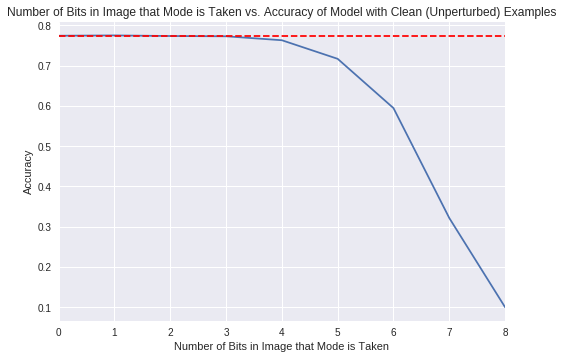

In [0]:
x = [0,1,2,3,4,5,6,7,8]
accs_copy = clean_accs
x_adv = [0.7745]*9
import matplotlib.pyplot as plt
plt.plot(accs_copy)
plt.plot(x_adv, 'r--')
plt.ylabel('Accuracy')
plt.xlabel('Number of Bits in Image that Mode is Taken')
plt.title('Number of Bits in Image that Mode is Taken vs. Accuracy of Model with Clean (Unperturbed) Examples')
plt.xlim(0, 8)
plt.show()

##  CW Attack Evaluation with Slicing Defense


### Learning Rate: 0.07

In [0]:
CW_LR_07_accs = []
for i in range(0, 9):
  print ("Testing with ", i, " bits")
  x_test = np.load('attack_images_np_CW_LR_07.npy')
  x_test *= 255
  x_test = x_test.astype('int')
  x_test = slice(x_test, i)
  x_test = x_test.astype('float32')
  x_test /= 255
  acc = classifier.evaluate(x_test, y_test)
  CW_LR_07_accs.append(acc[1])


Testing with  0  bits
10000/10000 [==============================] - 2s 166us/sample - loss: 2.2195 - acc: 0.1428
Testing with  1  bits
10000/10000 [==============================] - 2s 183us/sample - loss: 2.2180 - acc: 0.1542
Testing with  2  bits
10000/10000 [==============================] - 2s 188us/sample - loss: 2.2051 - acc: 0.1817
Testing with  3  bits
10000/10000 [==============================] - 2s 185us/sample - loss: 2.1584 - acc: 0.2217
Testing with  4  bits
10000/10000 [==============================] - 2s 189us/sample - loss: 2.0301 - acc: 0.2770
Testing with  5  bits
10000/10000 [==============================] - 2s 185us/sample - loss: 1.8063 - acc: 0.3373
Testing with  6  bits
10000/10000 [==============================] - 2s 181us/sample - loss: 1.7088 - acc: 0.3986
Testing with  7  bits
10000/10000 [==============================] - 2s 178us/sample - loss: 2.6844 - acc: 0.2772
Testing with  8  bits
10000/10000 [==============================] - 2s 164us/sample - l

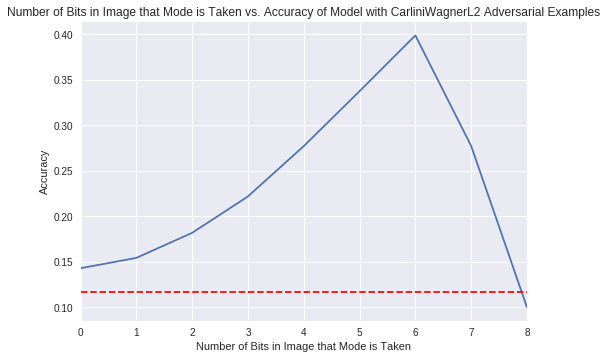

In [0]:
x = [0,1,2,3,4,5,6,7,8]
accs_copy = CW_LR_07_accs
x_adv = [0.1171]*9
import matplotlib.pyplot as plt
plt.plot(accs_copy)
plt.plot(x_adv, 'r--')
plt.ylabel('Accuracy')
plt.xlabel('Number of Bits in Image that Mode is Taken')
plt.title('Number of Bits in Image that Mode is Taken vs. Accuracy of Model with CarliniWagnerL2 Adversarial Examples')
plt.xlim(0, 8)
plt.show()


## FGSM Attack Evaluation Using Slicing Defense



### Epsilon 0.005


In [0]:
FGSM_005_accs = []
for i in range(0, 9):
  print ("Testing with ", i, " bits")
  x_test = np.load('attack_images_np_FGSM_eps_005.npy')
  x_test *= 255
  x_test = x_test.astype('int')
  x_test = slice(x_test, i)
  x_test = x_test.astype('float32')
  x_test /= 255
  acc = classifier.evaluate(x_test, y_test)
  FGSM_005_accs.append(acc[1])

Testing with  0  bits
10000/10000 [==============================] - 2s 155us/sample - loss: 1.5288 - acc: 0.5002
Testing with  1  bits
10000/10000 [==============================] - 2s 151us/sample - loss: 1.5233 - acc: 0.5018
Testing with  2  bits
10000/10000 [==============================] - 2s 155us/sample - loss: 1.5009 - acc: 0.5076
Testing with  3  bits
10000/10000 [==============================] - 2s 157us/sample - loss: 1.4389 - acc: 0.5229
Testing with  4  bits
10000/10000 [==============================] - 2s 154us/sample - loss: 1.3230 - acc: 0.5507
Testing with  5  bits
10000/10000 [==============================] - 2s 164us/sample - loss: 1.2579 - acc: 0.5759
Testing with  6  bits
10000/10000 [==============================] - 2s 167us/sample - loss: 1.4373 - acc: 0.5283
Testing with  7  bits
10000/10000 [==============================] - 2s 160us/sample - loss: 2.6743 - acc: 0.3056
Testing with  8  bits
10000/10000 [==============================] - 2s 165us/sample - l

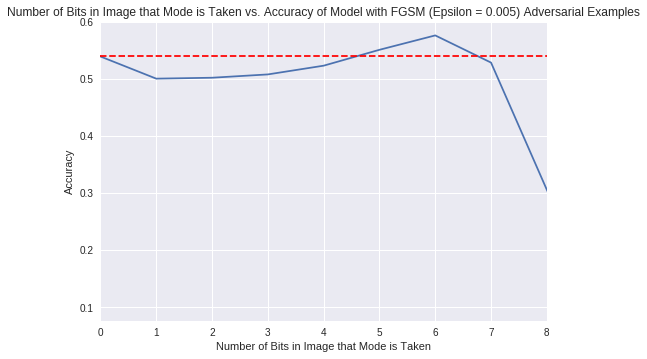

In [0]:
x = [0,1,2,3,4,5,6,7,8]
accs_copy = FGSM_005_accs
accs_copy = [.539]+ accs_copy
x_adv = [0.539]*9
# accs_copy = x
# accs_copy = x+accs_copy
import matplotlib.pyplot as plt
plt.plot(accs_copy)
plt.plot(x_adv, 'r--')
plt.ylabel('Accuracy')
plt.xlabel('Number of Bits in Image that Mode is Taken')
plt.title('Number of Bits in Image that Mode is Taken vs. Accuracy of Model with FGSM (Epsilon = 0.005) Adversarial Examples')
plt.xlim(0, 8)
plt.show()

### Epsilon 0.009


In [0]:
FGSM_009_accs = []
for i in range(0, 9):
  print ("Testing with ", i, " bits")
  x_test = np.load('attack_images_np_FGSM_eps_009.npy')
  x_test *= 255
  x_test = x_test.astype('int')
  x_test = slice(x_test, i)
  x_test = x_test.astype('float32')
  x_test /= 255
  acc = classifier.evaluate(x_test, y_test)
  FGSM_009_accs.append(acc[1])

Testing with  0  bits
10000/10000 [==============================] - 2s 166us/sample - loss: 2.0185 - acc: 0.3765
Testing with  1  bits
10000/10000 [==============================] - 2s 155us/sample - loss: 2.0117 - acc: 0.3774
Testing with  2  bits
10000/10000 [==============================] - 2s 159us/sample - loss: 1.9888 - acc: 0.3820
Testing with  3  bits
10000/10000 [==============================] - 2s 161us/sample - loss: 1.9172 - acc: 0.3956
Testing with  4  bits
10000/10000 [==============================] - 2s 160us/sample - loss: 1.7412 - acc: 0.4252
Testing with  5  bits
10000/10000 [==============================] - 2s 160us/sample - loss: 1.5170 - acc: 0.4815
Testing with  6  bits
10000/10000 [==============================] - 2s 164us/sample - loss: 1.5417 - acc: 0.4810
Testing with  7  bits
10000/10000 [==============================] - 2s 177us/sample - loss: 2.7024 - acc: 0.2926
Testing with  8  bits
10000/10000 [==============================] - 2s 186us/sample - l

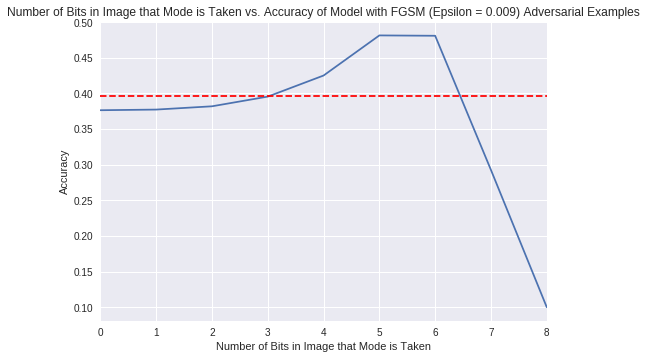

In [0]:
x = [0,1,2,3,4,5,6,7,8]
accs_copy = FGSM_009_accs
x_adv = [0.397]*9

import matplotlib.pyplot as plt
plt.plot(accs_copy)
plt.plot(x_adv, 'r--')
plt.ylabel('Accuracy')
plt.xlabel('Number of Bits in Image that Mode is Taken')
plt.title('Number of Bits in Image that Mode is Taken vs. Accuracy of Model with FGSM (Epsilon = 0.009) Adversarial Examples')
plt.xlim(0, 8)
plt.show()

### Epsilon 0.02


In [0]:
FGSM_02_accs = []
for i in range(0, 9):
  print ("Testing with ", i, " bits")
  x_test = np.load('attack_images_np_FGSM_eps_02.npy')
  x_test *= 255
  x_test = x_test.astype('int')
  x_test = slice(x_test, i)
  x_test = x_test.astype('float32')
  x_test /= 255
  acc = classifier.evaluate(x_test, y_test)
  FGSM_02_accs.append(acc[1])

Testing with  0  bits
10000/10000 [==============================] - 1s 148us/sample - loss: 2.6926 - acc: 0.2231
Testing with  1  bits
10000/10000 [==============================] - 2s 155us/sample - loss: 2.6884 - acc: 0.2231
Testing with  2  bits
10000/10000 [==============================] - 2s 156us/sample - loss: 2.6724 - acc: 0.2262
Testing with  3  bits
10000/10000 [==============================] - 2s 151us/sample - loss: 2.6151 - acc: 0.2295
Testing with  4  bits
10000/10000 [==============================] - 2s 152us/sample - loss: 2.4404 - acc: 0.2437
Testing with  5  bits
10000/10000 [==============================] - 2s 155us/sample - loss: 2.0774 - acc: 0.2921
Testing with  6  bits
10000/10000 [==============================] - 2s 171us/sample - loss: 1.8178 - acc: 0.3546
Testing with  7  bits
10000/10000 [==============================] - 2s 165us/sample - loss: 2.7297 - acc: 0.2628
Testing with  8  bits
10000/10000 [==============================] - 2s 160us/sample - l

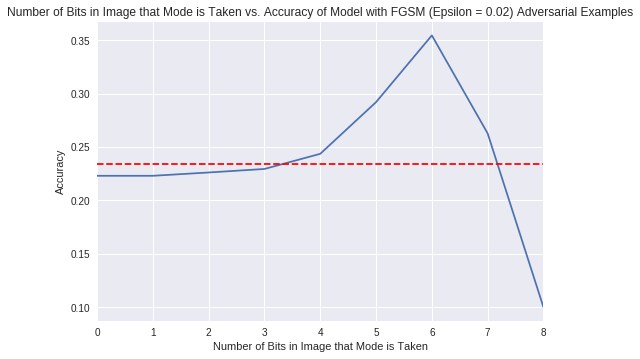

In [0]:
x = [0,1,2,3,4,5,6,7,8]
accs_copy = FGSM_02_accs
x_adv = [0.2339]*9


import matplotlib.pyplot as plt
plt.plot(accs_copy)
plt.plot(x_adv, 'r--')
plt.ylabel('Accuracy')
plt.xlabel('Number of Bits in Image that Mode is Taken')
plt.title('Number of Bits in Image that Mode is Taken vs. Accuracy of Model with FGSM (Epsilon = 0.02) Adversarial Examples')
plt.xlim(0, 8)
plt.show()

### Epsilon 0.04

In [0]:
FGSM_04_accs = []
for i in range(0, 9):
  print ("Testing with ", i, " bits")
  x_test = np.load('attack_images_np_FGSM_eps_04.npy')
  x_test *= 255
  x_test = x_test.astype('int')
  x_test = slice(x_test, i)
  x_test = x_test.astype('float32')
  x_test /= 255
  acc = classifier.evaluate(x_test, y_test)
  FGSM_04_accs.append(acc[1])

Testing with  0  bits
10000/10000 [==============================] - 1s 149us/sample - loss: 2.8501 - acc: 0.1643
Testing with  1  bits
10000/10000 [==============================] - 2s 159us/sample - loss: 2.8462 - acc: 0.1645
Testing with  2  bits
10000/10000 [==============================] - 2s 166us/sample - loss: 2.8357 - acc: 0.1653
Testing with  3  bits
10000/10000 [==============================] - 2s 164us/sample - loss: 2.8039 - acc: 0.1661
Testing with  4  bits
10000/10000 [==============================] - 2s 165us/sample - loss: 2.6955 - acc: 0.1705
Testing with  5  bits
10000/10000 [==============================] - 2s 170us/sample - loss: 2.4154 - acc: 0.1860
Testing with  6  bits
10000/10000 [==============================] - 2s 171us/sample - loss: 2.0861 - acc: 0.2383
Testing with  7  bits
10000/10000 [==============================] - 2s 160us/sample - loss: 2.7213 - acc: 0.2268
Testing with  8  bits
10000/10000 [==============================] - 2s 159us/sample - l

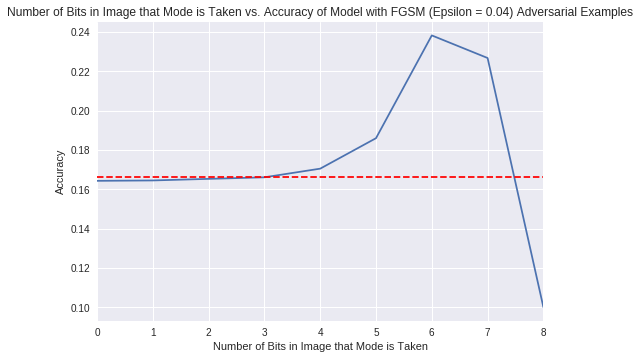

In [0]:
x = [0,1,2,3,4,5,6,7,8]
accs_copy = FGSM_04_accs
x_adv = [0.1665]*9


import matplotlib.pyplot as plt
plt.plot(accs_copy)
plt.plot(x_adv, 'r--')
plt.ylabel('Accuracy')
plt.xlabel('Number of Bits in Image that Mode is Taken')
plt.title('Number of Bits in Image that Mode is Taken vs. Accuracy of Model with FGSM (Epsilon = 0.04) Adversarial Examples')
plt.xlim(0, 8)
plt.show()

### Epsilon 0.07

In [0]:
FGSM_07_accs = []
for i in range(0, 9):
  print ("Testing with ", i, " bits")
  x_test = np.load('attack_images_np_FGSM_eps_07.npy')
  x_test *= 255
  x_test = x_test.astype('int')
  x_test = slice(x_test, i)
  x_test = x_test.astype('float32')
  x_test /= 255
  acc = classifier.evaluate(x_test, y_test)
  FGSM_07_accs.append(acc[1])

Testing with  0  bits
10000/10000 [==============================] - 2s 164us/sample - loss: 2.5894 - acc: 0.1391
Testing with  1  bits
10000/10000 [==============================] - 2s 177us/sample - loss: 2.5877 - acc: 0.1402
Testing with  2  bits
10000/10000 [==============================] - 2s 162us/sample - loss: 2.5877 - acc: 0.1401
Testing with  3  bits
10000/10000 [==============================] - 2s 170us/sample - loss: 2.5751 - acc: 0.1394
Testing with  4  bits
10000/10000 [==============================] - 2s 168us/sample - loss: 2.5368 - acc: 0.1410
Testing with  5  bits
10000/10000 [==============================] - 2s 166us/sample - loss: 2.4452 - acc: 0.1488
Testing with  6  bits
10000/10000 [==============================] - 2s 159us/sample - loss: 2.2445 - acc: 0.1752
Testing with  7  bits
10000/10000 [==============================] - 2s 158us/sample - loss: 2.6165 - acc: 0.1962
Testing with  8  bits
10000/10000 [==============================] - 2s 161us/sample - l

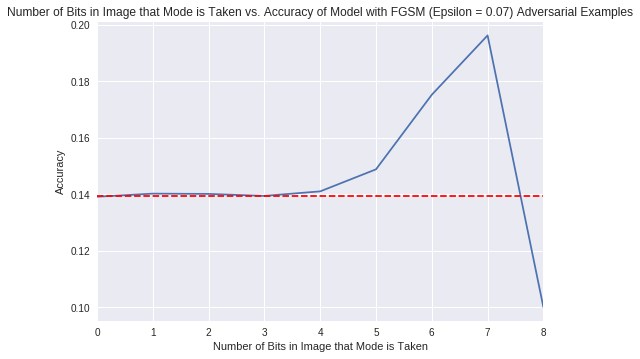

In [0]:
x = [0,1,2,3,4,5,6,7,8]
accs_copy = FGSM_07_accs
x_adv = [0.1392]*9


import matplotlib.pyplot as plt
plt.plot(accs_copy)
plt.plot(x_adv, 'r--')
plt.ylabel('Accuracy')
plt.xlabel('Number of Bits in Image that Mode is Taken')
plt.title('Number of Bits in Image that Mode is Taken vs. Accuracy of Model with FGSM (Epsilon = 0.07) Adversarial Examples')
plt.xlim(0, 8)
plt.show()

### Saving Model Accuracies for Different Attacks

In [0]:
import pickle

with open("Clean_Mode.pickle", "wb") as fp:   #Pickling Clean Bit Mode Images Model Accuracies 
  pickle.dump(clean_accs, fp)
  
with open("CW_Mode.pickle", "wb") as fp:   #Pickling CW Attack Bit Mode Images Model Accuracies
  pickle.dump(CW_LR_07_accs, fp)
  
with open("FGSM_005_Mode.pickle", "wb") as fp:   #Pickling FGSM 0.005 Attack Bit Mode Images Model Accuracies
  pickle.dump(FGSM_005_accs, fp)

with open("FGSM_009_Mode.pickle", "wb") as fp:   #Pickling FGSM 0.009 Attack Bit Mode Images Model Accuracies
  pickle.dump(FGSM_009_accs, fp)

with open("FGSM_02_Mode.pickle", "wb") as fp:   #Pickling FGSM 0.02 Attack Bit Mode Images Model Accuracies
  pickle.dump(FGSM_02_accs, fp)
  
with open("FGSM_04_Mode.pickle", "wb") as fp:   #Pickling FGSM 0.04 Attack Bit Mode Images Model Accuracies
  pickle.dump(FGSM_04_accs, fp)
  
with open("FGSM_07_Mode.pickle", "wb") as fp:   #Pickling FGSM 0.07 Attack Bit Mode Images Model Accuracies
  pickle.dump(FGSM_07_accs, fp)